In [4]:
### Financial News Sentiment Analysis and EDA Notebook
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import os
import glob


In [125]:
# Load Financial Data
current_dir = os.getcwd()
financial_data_path = os.path.join(current_dir, "../data/yfinance_data")
all_files = glob.glob(os.path.join(financial_data_path, "*.csv"))

financial_dfs = []
for file in all_files:
   try:
        df = pd.read_csv(file)
        stock_name = os.path.basename(file).split('.')[0]
        df['stock'] = stock_name
        financial_dfs.append(df)
   except Exception as e:
        print(f"Error reading {file}: {e}")

In [126]:
financial_data = pd.concat(financial_dfs, ignore_index=True)

In [50]:
# Data Understanding
print("Dataset Info:")
financial_data.info()
print("\nDataset Preview:")
print(financial_data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45428 entries, 0 to 45427
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              45428 non-null  object 
 1   open              45428 non-null  float64
 2   high              45428 non-null  float64
 3   low               45428 non-null  float64
 4   close             45428 non-null  float64
 5   adj close         45428 non-null  float64
 6   volume            45428 non-null  int64  
 7   dividends         45428 non-null  float64
 8   stock splits      45428 non-null  float64
 9   stock             45428 non-null  object 
 10  price_change_pct  45428 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 3.8+ MB

Dataset Preview:
         date      open      high       low     close  adj close     volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.1

In [51]:
# Check Missing Values
missing_values = financial_data.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 date                0
open                0
high                0
low                 0
close               0
adj close           0
volume              0
dividends           0
stock splits        0
stock               0
price_change_pct    0
dtype: int64


In [123]:
# Preprocess Financial Data
financial_data['date'] = pd.to_datetime(financial_data['date'])
financial_data.rename(columns=str.lower, inplace=True)

In [124]:
# Calculate Price Change Percentages
financial_data['price_change_pct'] = ((financial_data['close'] - financial_data['open']) / financial_data['open']) * 100

In [21]:
# Load Raw Analyst Data
raw_data_analyst = os.path.join(current_dir, "../data/raw_analyst_ratings/raw_analyst_ratings.csv")
analyst_data = pd.read_csv(raw_data_analyst)

In [61]:
# Preprocess Financial Data
analyst_data['date'] = pd.to_datetime(analyst_data['date'])
analyst_data.rename(columns=str.lower, inplace=True)

In [83]:
# Merge Analyst Data with Financial Data
merged_data = pd.merge(
    analyst_data, 
    financial_data, 
    left_on=['date', 'stock'], 
    right_on=['date', 'stock'], 
    how='inner'
)


In [120]:
# Drop unused columns
merged_data.drop(columns=['date'], inplace=True)

### Descriptive Statistics

In [87]:
# Check Missing Values
missing_values = merged_data.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 unnamed: 0            0
headline              0
url                   0
publisher             0
stock                 0
headline_length       0
sentiment             0
sentiment_category    0
open                  0
high                  0
low                   0
close                 0
adj close             0
volume                0
dividends             0
stock splits          0
price_change_pct      0
dtype: int64


In [88]:
# Headline Length Analysis
merged_data['headline_length'] = merged_data['headline'].apply(len)
print("\nHeadline Length Statistics:")
print(merged_data['headline_length'].describe())


Headline Length Statistics:
count     49.000000
mean      87.571429
std       45.321077
min       33.000000
25%       56.000000
50%       81.000000
75%      106.000000
max      216.000000
Name: headline_length, dtype: float64


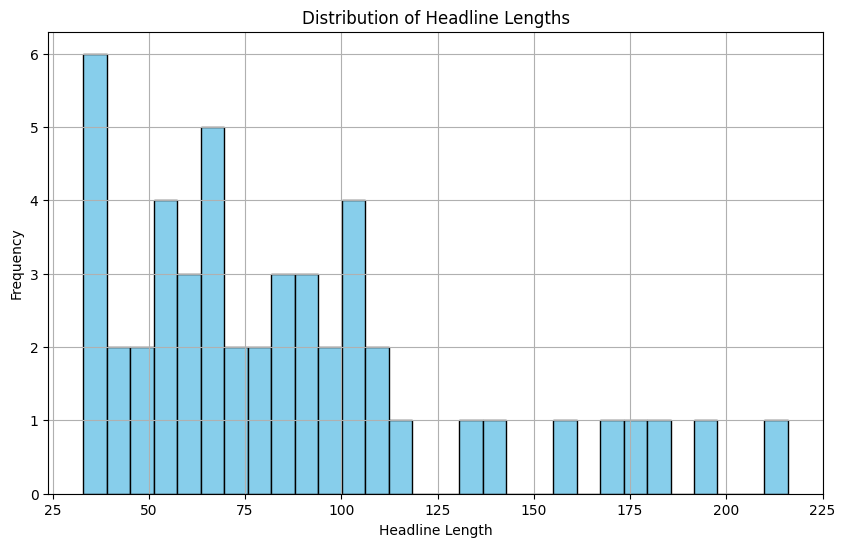

In [89]:
plt.figure(figsize=(10, 6))
merged_data['headline_length'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()


Top 10 Publishers:
 publisher
Benzinga Newsdesk    16
Benzinga Insights     5
Neer Varshney         5
Benzinga Newsdesk     3
Shivdeep Dhaliwal     3
Shanthi Rexaline      3
JJ Kinahan            2
Jaycee Tenn           2
Tanzeel Akhtar        2
Priya Nigam           1
Name: count, dtype: int64


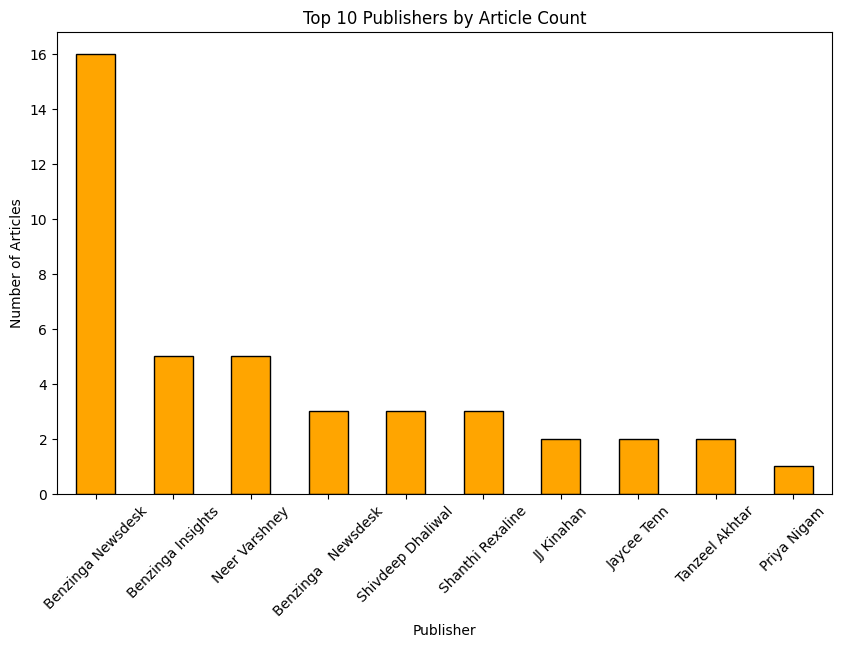

In [101]:
# Convert 'date' columns to datetime in both DataFrames
analyst_data['date'] = pd.to_datetime(analyst_data['date'], errors='coerce')
financial_data['date'] = pd.to_datetime(financial_data['date'], errors='coerce')




        date
0 2020-06-05
1 2020-06-03
2 2020-05-26
3 2020-05-22
4 2020-05-22
        date
0 1980-12-12
1 1980-12-15
2 1980-12-16
3 1980-12-17
4 1980-12-18


In [102]:
# Merge the data again after ensuring 'date' columns are in datetime format
merged_data = pd.merge(
    analyst_data,
    financial_data,
    left_on=['stock', 'date'],
    right_on=['stock', 'date'],
    how='inner'
)

# Check the merged data to verify
print(merged_data.head())


   unnamed: 0                                           headline  \
0        7120  Tech Stocks And FAANGS Strong Again To Start D...   
1        7121      10 Biggest Price Target Changes For Wednesday   
2        7122  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
3        7123  Deutsche Bank Maintains Buy on Apple, Raises P...   
4        7124  Apple To Let Users Trade In Their Mac Computer...   

                                                 url          publisher  \
0  https://www.benzinga.com/government/20/06/1622...         JJ Kinahan   
1  https://www.benzinga.com/analyst-ratings/price...         Lisa Levin   
2  https://www.benzinga.com/short-sellers/20/06/1...  Benzinga Newsdesk   
3  https://www.benzinga.com/news/20/06/16219873/d...  Benzinga Newsdesk   
4  https://www.benzinga.com/news/20/06/16218697/a...      Neer Varshney   

        date stock  headline_length  sentiment sentiment_category       open  \
0 2020-06-10  AAPL               69   0.433333           pos

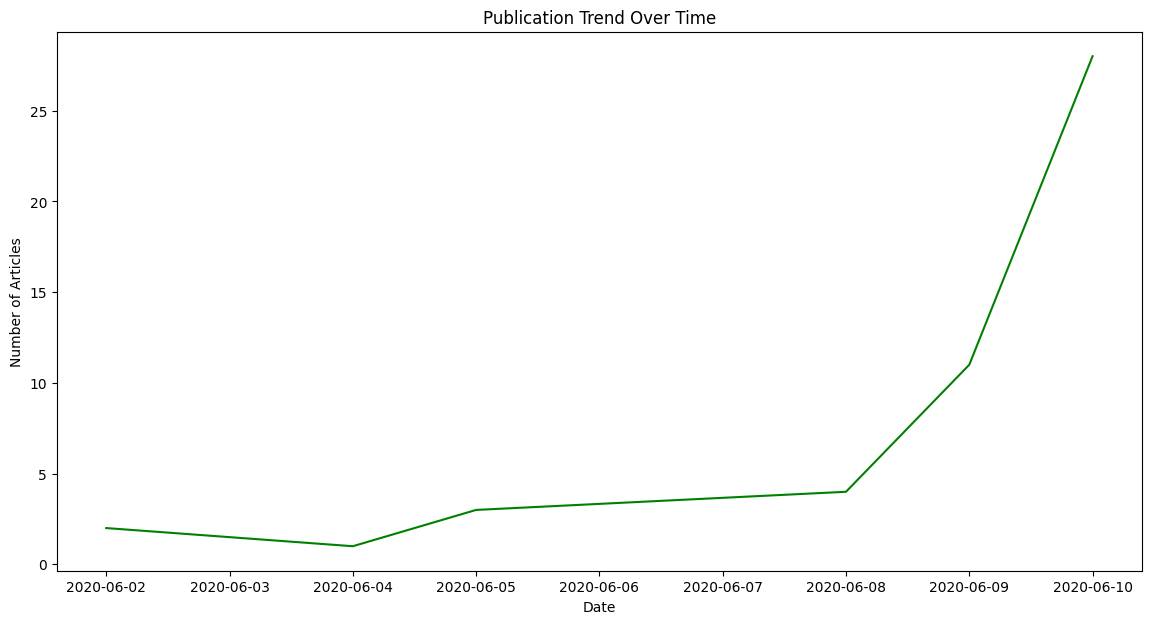

In [103]:
# Publication Date Trends
daily_counts = merged_data['date'].dt.date.value_counts().sort_index()
plt.figure(figsize=(14, 7))
daily_counts.plot(kind='line', color='green')
plt.title('Publication Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

### Sentiment Analysis

In [104]:
# Add Sentiment Scores
merged_data['sentiment'] = merged_data['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [105]:
# Categorize Sentiment
merged_data['sentiment_category'] = pd.cut(
    merged_data['sentiment'], bins=[-1, -0.01, 0.01, 1], labels=['negative', 'neutral', 'positive']
)


In [106]:
# Sentiment Distribution
sentiment_distribution = merged_data['sentiment_category'].value_counts()
print("\nSentiment Distribution:\n", sentiment_distribution)


Sentiment Distribution:
 sentiment_category
neutral     25
positive    21
negative     3
Name: count, dtype: int64


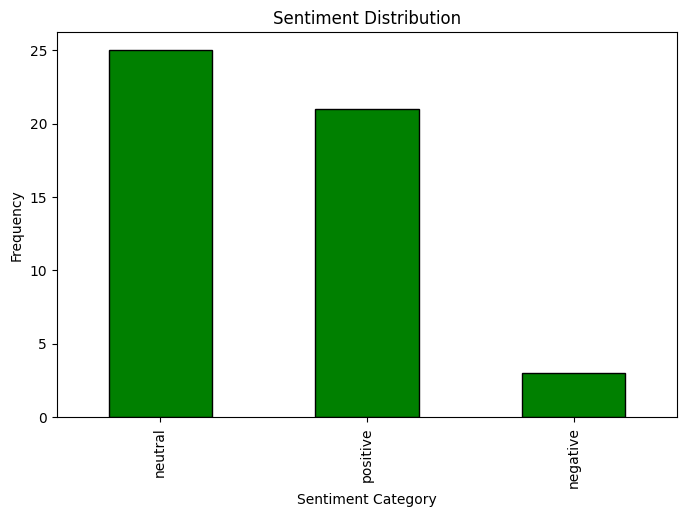

In [107]:
plt.figure(figsize=(8, 5))
sentiment_distribution.plot(kind='bar', color='green', edgecolor='black')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.show()

In [108]:
### Topic Modeling
# Vectorize Headlines
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(merged_data['headline'])

In [109]:
# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [110]:
# Display Topics
print("\nTopics Identified:")
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])



Topics Identified:
Topic 1:
['big', 'reaches', 'record', 'tech', 'new', 'morning', 'afternoon', 'market', 'minutes', 'stats']
Topic 2:
['mark', 'twitter', 'juneteenth', 'culture', 'holiday', 'african', 'american', 'honor', 'square', 'stocks']
Topic 3:
['cannabis', 'marketing', 'cannaphyll', 'platforms', 'mass', 'consumer', '000', 'target', 'tesla', 'amazon']
Topic 4:
['ramp', 'market', 'tech', 'stocks', 'start', 'strong', 'day', 'faangs', 'fed', 'awaits']
Topic 5:
['tesla', 'market', 'apple', 'stock', 'company', 'weakness', 'despite', 'shares', 'higher', 'trading']


### Time Series Analysis

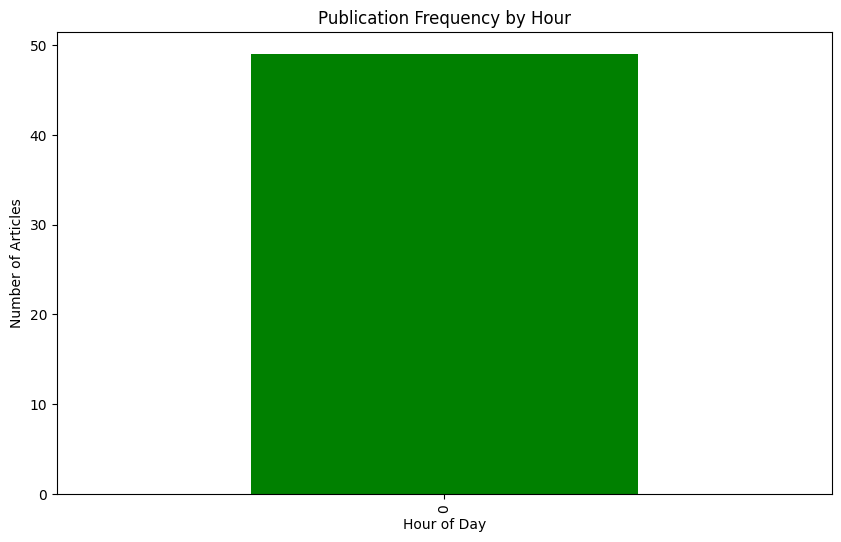

In [116]:
# Publication Hour Analysis
hourly_counts = merged_data['date'].dt.hour.value_counts().sort_index()
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind='bar', color='green')
plt.title('Publication Frequency by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.show()

### Correlation with Market Data

In [118]:
# Calculate Price Change
merged_data['price_change'] = merged_data['close'] - merged_data['open']

In [119]:
# Correlation Analysis
sentiment_correlation = merged_data[['sentiment', 'price_change']].corr()
print("\nCorrelation Between Sentiment and Price Change:\n", sentiment_correlation)


Correlation Between Sentiment and Price Change:
               sentiment  price_change
sentiment      1.000000     -0.184013
price_change  -0.184013      1.000000


In [122]:
### Save Processed Data
processed_data_path = os.path.join(current_dir, "../data/processed_data")
file_path = os.path.join(processed_data_path, "processed_financial_news.csv")
# Save the merged data to the file
merged_data.to_csv(file_path, index=False)

print(f"Data saved to {file_path}")


Data saved to c:\Users\hp\Desktop\Academic_Folders\Kifiya AI Mastery\week 1\Nova-Financial-Solutions\notebooks\../data/processed_data\processed_financial_news.csv
